# Comparison of different neural network architectures for evolving reinforcement learning agents
---

## Imports

In [1]:
# Install packages for rendering in Colab
!apt-get update
!apt install xvfb 
!apt-get install x11-utils > /dev/null 2>&1
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [787 kB]
Get:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 k

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Imports
import os
import shutil
import random
import copy
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
import numpy as np
import pandas as pd
import torch

In [4]:
# Create an environment
env_name = 'CartPole-v1'
env = gym.make(env_name) # create the gym environment
env.reset()
print(f"Action space {env.action_space} \nObservation space {env.observation_space}")

Action space Discrete(2) 
Observation space Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


In [5]:
NUM_OBS = 4
NUM_ACTIONS = 1

In [6]:
def run_episode(env, agent):
    '''
    Run a single episode
    :return: total reward from an episode
    '''
    tot_reward = 0.0
    obs = env.reset()
    done = False
    while not done:
        action = agent.get_action(obs)
        obs, reward, done, info = env.step(action)
        tot_reward = tot_reward + reward
    return tot_reward

21.0

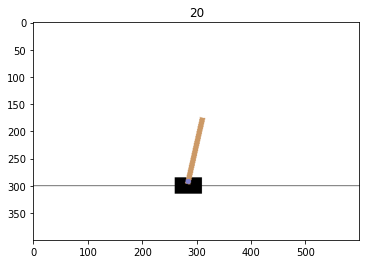

In [7]:
def visual_episode(env, agent=None):
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()
    prev_screen = env.render(mode='rgb_array')
    plt.imshow(prev_screen)

    tot_reward = 0.0
    obs = env.reset()
    done = False
    curr_t = 0
    while not done:
        if agent is not None:
            action = agent.get_action(obs)
        else:
            action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        screen = env.render(mode='rgb_array')
        tot_reward = tot_reward + reward

        plt.imshow(screen)
        plt.title(curr_t)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())
        curr_t = curr_t + 1

    ipythondisplay.clear_output(wait=True)
    env.close()
    return tot_reward

visual_episode(env)

## Agent

In [8]:
class Agent:
    def __init__(self, num_input, num_output, layers=[]):
        self.num_input = num_input
        self.num_output = num_output 
        self.layers = np.uint8(np.concatenate((layers,[num_output])))
        self.num_genes = self.set_num_genes()
        self.weights = None
        self.bias = None
    
    def set_num_genes(self):
        '''
        Set the number of weights and biases for the network
        '''
        num_genes = 0
        prev_layer_size = self.num_input
        for layer_size in self.layers:
            num_genes += prev_layer_size * layer_size + layer_size
            prev_layer_size = layer_size  
        return num_genes
    
    def set_genes(self, gene):
        '''
        Map a list of genes to the list of weights and biases
        :param: genotype of length num_genes
        '''
        weights = []
        bias = []
        prev_layer_size = self.num_input
        for layer_size in self.layers:
            num_edges = prev_layer_size*layer_size
            w = gene[0:num_edges].reshape(prev_layer_size, layer_size) 
            b = gene[num_edges:num_edges+layer_size].reshape(layer_size,) 
            weights.append(w)
            bias.append(b)
            gene = gene[num_edges+layer_size:]
            prev_layer_size = layer_size
        self.weights = weights
        self.bias = bias
    
    def forward(self, x):
        '''
        Forward pass
        :param x: observations from the environment
        '''
        x = torch.from_numpy(x).unsqueeze(0)
        for i in range(len(self.layers)):
            w = torch.from_numpy(self.weights[i])
            b = torch.from_numpy(self.bias[i]).unsqueeze(0)
            out = torch.mm(x, w) + b
            if i < self.layers.shape[0]-1: # apply leaky relu to hidden layers
                m = torch.nn.LeakyReLU(0.1)
                out = m(out)
            x = out
        return out

    def get_action(self, x):
        if self.forward(x) > 0:
            return 1
        else:
            return 0

## Optimization

In [9]:
def fitness_function(env, agent, gene_pop):
    '''
    Calculate total reward from the environment for each genotype in population
    :param gene_pop: an array of genotypes of shape (pop_size, num_genes)
    :return: an array of fitnesses for each genotype in a given population
    '''
    pop_size = gene_pop.shape[0]
    pop_fitness = np.zeros(pop_size)
    for i, gene in enumerate(gene_pop):
        agent.set_genes(gene)
        pop_fitness[i] = run_episode(env, agent)
    
    return pop_fitness

In [10]:
def mutation_function(gene_pop, noise='gaussian', mean=0, std=0.1):
    '''
    Mutate each gene in population by adding noise from Gaussian or Cauchy diistribution
    :param gene_pop: an array of genotypes of shape (pop_size, num_genes)
    :param noise: distribution used for adding noise, allowed values: 'gaussian', 'cauchy'
    :return: a new population where mutation is applied to each gene
    '''
    gene_pop = np.copy(gene_pop)
    for i, gene in enumerate(gene_pop):
        if noise=='gaussian':
            gene_pop[i] = gene_pop[i] + np.random.normal(mean, std, size=gene.shape)
        elif noise=='cauchy':
            gene_pop[i] = gene_pop[i] + np.random.standard_cauchy(size=gene.shape)
        else:
            print('Incorrect noise parameter')

    # Constraints so that values are not too small or too big
    gene_pop[gene_pop > 4] = 4
    gene_pop[gene_pop < -4] = -4

    return gene_pop


In [11]:
def selection_function(prev_gene_pop, gene_pop, prev_fitness, fitness):
    '''
    Determine if the mutation was beneficial. 
    Accept the mutated value if it was an improvement, otherwise keep the original value.
    '''
    new_gene_pop = np.zeros_like(gene_pop)
    for i, gene in enumerate(gene_pop):
        if fitness[i] >= prev_fitness[i]:
            new_gene_pop[i] = gene_pop[i]
        else:
            new_gene_pop[i] = prev_gene_pop[i]
    
    return new_gene_pop

In [12]:
def get_best_gene(gene_pop, fitness):
    '''
    Get best gene from the population
    '''
    i = np.argmax(fitness)
    return gene_pop[i]

### Hill Climbing

In [13]:
def run_hillclimber(env, agent, mutation_noise, mutation_std=0.01, pop_size=15, epochs=1000, label='', return_pop=True, draw_plot=None):
    '''
    Run a population of hillclimbers
    :param mutation_noise: noise param for mutation function, either 'gaussian' or 'cauchy'
    :param mutation_std: standart devation for mutation function if 'gaussian' noise is chosen, ignored for 'cauchy'
    :param pop_size: size of the population to be created
    :param epochs: number of algorithm runs
    :param draw_plot: if not None, draw a figure; accepted values: {'mean','max}
    :param label: the label to add to the figure
    :param return_pop: if True return final gene population
    :return: a tuple where the first item contains the best gene and the second item contains max fitness for each episode, 
             if return_pop is True, final gene population is also returned
    '''

    # Create gene population
    gene_pop = np.random.normal(0, 0.1, (pop_size, agent.num_genes))

    # Get initial fitness of the population
    fitness = fitness_function(env, agent, gene_pop)

    prev_fitness = fitness
    prev_gene_pop = gene_pop
    mean_fitness = [] # mean pop fitness for each epoch
    max_fitness = [] # max fitness in pop for each epoch
    best_gene_epoch = {} # best gene in each epoch
    
    # Main loop
    for epoch in range(epochs):

        # Store the best gene at current epoch
        best_gene_epoch[epoch] = get_best_gene(gene_pop, fitness)

        # Mutate population
        gene_pop = mutation_function(prev_gene_pop, noise=mutation_noise, std=mutation_std)

        # Get fitness of the mutated population
        fitness = fitness_function(env, agent, gene_pop)

        # Apply selection 
        gene_pop = selection_function(prev_gene_pop, gene_pop, prev_fitness, fitness)

        # Evaluated the fitness of the selected population
        prev_fitness = fitness_function(env, agent, gene_pop)
        prev_gene_pop = gene_pop
  
        mean_fitness.append(prev_fitness.mean())
        max_fitness.append(prev_fitness.max())

    # Visualise fitness
    if draw_plot=='mean':
        plt.plot(mean_fitness, label=label)
    elif draw_plot=='max':
        plt.plot(max_fitness, label=label)
    elif not draw_plot is None:
        print("Incorrect value for draw_plot, accepted values: {'mean','max}")

    results = (best_gene_epoch, max_fitness)

    if return_pop:
        return results, gene_pop
    else:
        return results

### Choosing mutation function parameters

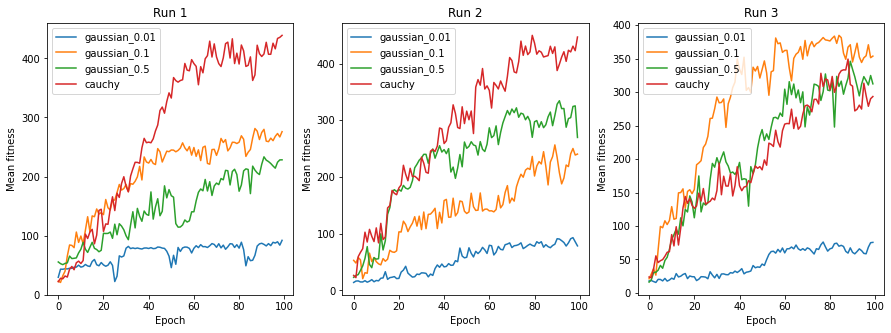

In [14]:
# Create agent
agent = Agent(NUM_OBS, NUM_ACTIONS)
epochs = 100

# Visualise the behaviour with different mutation funtion parameters
plt.rcParams['figure.figsize'] = [15, 5]
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title(f'Run {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Mean fitness')
    
    _,_ = run_hillclimber(env, agent, mutation_noise='gaussian', 
                          mutation_std=0.01, epochs=epochs, label='gaussian_0.01', 
                          draw_plot='mean', return_pop=False)
    
    _,_ = run_hillclimber(env, agent, mutation_noise='gaussian', 
                          mutation_std=0.1, epochs=epochs, label='gaussian_0.1', 
                          draw_plot='mean', return_pop=False)
    
    _,_ = run_hillclimber(env, agent, mutation_noise='gaussian', 
                          mutation_std=0.5, epochs=epochs, label='gaussian_0.5', 
                          draw_plot='mean', return_pop=False)
    
    _,_ = run_hillclimber(env, agent, mutation_noise='cauchy', 
                          epochs=epochs, label='cauchy', 
                          draw_plot='mean', return_pop=False)
    plt.legend()

plt.savefig("mutation.png", bbox_inches = 'tight')
plt.show()

## Results

### Evolution of fitness

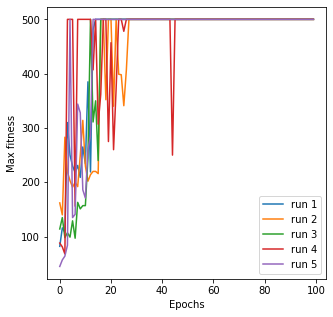

In [104]:
# NOTE: THIS CELL WILL TAKE A LONG TIME TO EXECUTE
num_runs = 5
epochs = 100

# Visualise how the controller is evolving as the number of epochs increases
plt.rcParams['figure.figsize'] = [5, 5]
plt.xlabel('Epochs')
plt.ylabel('Max fitness')
for i in range(num_runs):
    _,_ = run_hillclimber(env, agent, mutation_noise='cauchy', 
                          epochs=epochs, label=f'run {i+1}', 
                          draw_plot='max', return_pop=False)
    plt.legend()

plt.savefig("max_fit.png", bbox_inches = 'tight')
plt.show()

### Comparing network architectures

In [105]:
# Initialize agents with different parameters
agents = {
          'sl': Agent(NUM_OBS, NUM_ACTIONS), # single layer agent
          '1h_2': Agent(NUM_OBS, NUM_ACTIONS, layers=[2]), # 1 hidden layer with 4 units
          '1h_4':  Agent(NUM_OBS, NUM_ACTIONS, layers=[4]), # 1 hidden layer with 4 units
          '2h_2_2':  Agent(NUM_OBS, NUM_ACTIONS, layers=[2,2]), # 2 hidden layers with 2 and 2 units
          '2h_4_2':  Agent(NUM_OBS, NUM_ACTIONS, layers=[4,2]), # 2 hidden layers with 4 and 2 units
         }

In [106]:
def get_average_fitness(agent, num_runs, epochs):
    '''
    Measure how the controller's maximum fitness changes for multiple runs and take the average.
    '''
    fit = np.zeros((num_runs, epochs))
    for i in range(num_runs):
        _, max_fitness = run_hillclimber(env, agent, mutation_noise='cauchy', 
                                         epochs=epochs, return_pop=False)
        fit[i] = max_fitness
    
    fit_mean = np.mean(fit, axis=0)
    fit_std = np.std(fit, axis=0)

    return fit_mean, fit_std

In [ ]:
# NOTE: THIS CELL WILL TAKE A LONG TIME TO EXECUTE
num_runs = 10
epochs = 100

mean_results = {}
std_results = {}
for agent_name, agent in agents.items():
    mean, std = get_average_fitness(agent, num_runs, epochs)
    mean_results[agent_name] = mean
    std_results[agent_name] = std

In [193]:
idx = [1,10,20,30,50,80]
mean_results_df = pd.DataFrame.from_dict(mean_results)
mean_results_df = mean_results_df.iloc[idx,:]
mean_results_df

,sl,1h_2,1h_4,2h_2_2,2h_4_2
1,114.9,131.9,82.0,151.7,149.1
10,343.2,310.0,325.7,385.3,344.3
20,443.0,455.1,422.7,418.4,410.9
30,483.1,500.0,500.0,458.4,472.4
50,500.0,500.0,500.0,491.1,479.4
80,500.0,500.0,500.0,500.0,500.0


In [194]:
std_results_df = pd.DataFrame.from_dict(std_results)
std_results_df = std_results_df.iloc[idx,:]
std_results_df

,sl,1h_2,1h_4,2h_2_2,2h_4_2
1,86.972927,134.328292,38.251797,127.514744,123.594053
10,163.980975,140.898545,153.684124,153.588444,143.705985
20,90.436718,90.638237,95.502932,131.801517,113.020750
30,50.700000,0.000000,0.000000,75.352770,82.800000
50,0.000000,0.000000,0.000000,26.700000,61.800000
80,0.000000,0.000000,0.000000,0.000000,0.000000


### Evaluating the behaviour

In [17]:
def get_observations(env, agent):
    '''
    Run episode and get observations from the environment for each step
    '''
    obs = env.reset()
    done = False
    observations = []
    while not done:
        action = agent.get_action(obs)
        obs, reward, done, info = env.step(action)
        observations.append(obs)
    return observations

In [14]:
# Create agent
agent = Agent(NUM_OBS, NUM_ACTIONS, layers=[2])

In [56]:
# Run optimizer
_,gene_pop = run_hillclimber(env, agent, mutation_noise='cauchy', epochs=100, return_pop=True)

# Get best gene
fitness = fitness_function(env, agent, gene_pop)
best_gene = get_best_gene(gene_pop, fitness)

# Get observations 
agent.set_genes(best_gene)
obs = np.array(get_observations(env, agent))
obs = pd.DataFrame(data=obs, columns=['cart_position', 'cart_velocity', 'pole_angle', 'pole_angular_velocity'])

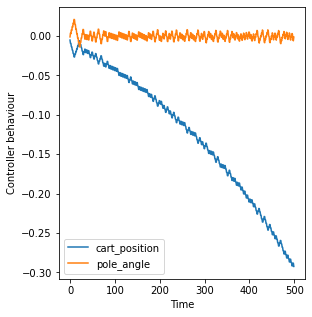

In [112]:
plt.rcParams['figure.figsize'] = [5, 5]

plt.xlabel('Time')
plt.ylabel('Controller behaviour')
for col in obs.iloc[:,[0,2]]:
    plt.plot(obs[col].values, label=col)
plt.legend()

plt.savefig("behaviour.png", bbox_inches = 'tight')
plt.show()

### Measuring accuracy

In [18]:
def get_accuracy(_env, _agent, gene, num_runs=1000):
    '''
    Compute controller accuracy over specified number of runs
    :param num_runs: number of episodes to consider
    '''
    agent.set_genes(gene)
    acc = []
    success = 0
    for i in range(num_runs):
        fitness = run_episode(_env, _agent)
        if fitness == 500.0:
            success += 1
        acc.append(fitness)
    
    plt.xlabel('Episodes')
    plt.ylabel('Fitness')
    plt.plot(acc)
    return success/num_runs

0.62

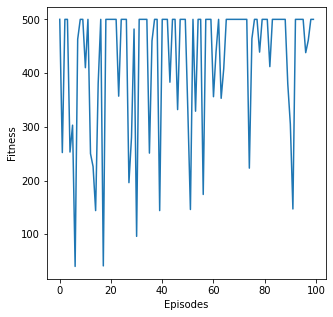

In [148]:
# Bad accuracy example, may be different if cell is run
# Run optimizer
_,gene_pop = run_hillclimber(env, agent, mutation_noise='cauchy', epochs=50, return_pop=True)

# Get best gene
fitness = fitness_function(env, agent, gene_pop)
best_gene = get_best_gene(gene_pop, fitness)

# Get accuracy
agent.set_genes(best_gene)
acc = get_accuracy(env, agent, best_gene, num_runs=100)
plt.savefig("bad_acc.png", bbox_inches = 'tight')
acc

0.97

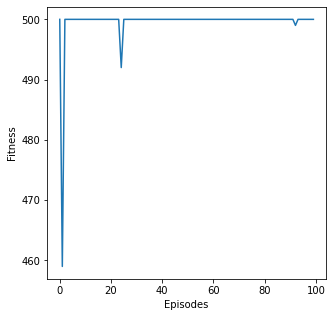

In [138]:
# Good accuracy example, may be different if cell is run
# Run optimizer
_,gene_pop = run_hillclimber(env, agent, mutation_noise='cauchy', epochs=50, return_pop=True)

# Get best gene
fitness = fitness_function(env, agent, gene_pop)
best_gene = get_best_gene(gene_pop, fitness)

# Get accuracy
agent.set_genes(best_gene)
acc = get_accuracy(env, agent, best_gene, num_runs=100)
plt.savefig("acc.png", bbox_inches = 'tight')
acc

## Saving visualisation

In [15]:
def save_vis(env, epoch, agent=None, dirname='sim_frames'):
    '''
    Save visualization of controller behavior in one episode
    :param dirname: directory where the images will be saved
    '''
    if os.path.isdir(dirname):
      shutil.rmtree(dirname)
    os.makedirs(dirname, exist_ok=True)
    tot_reward = 0.0
    obs = env.reset()
    done = False
    curr_t = 0
    while not done:
        if agent is not None:
            action = agent.get_action(obs)
        else:
            action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        screen = env.render(mode='rgb_array')
        tot_reward = tot_reward + reward
        plt.imshow(screen)
        plt.title(curr_t)
        plt.text(490, 30, f'epoch {epoch}')
        plt.savefig(os.path.join(dirname, 'fig{}-{}'.format(epoch, curr_t)))
        plt.show()
        curr_t += 1

In [ ]:
# NOTE: THIS CELL WILL TAKE A LONG TIME TO EXECUTE
!rm -rf sim_frames

best_gene_epoch,_ = run_hillclimber(env, agent, mutation_noise='cauchy', epochs=40, return_pop=False)

for epoch,gene in best_gene_epoch.items():
    agent.set_genes(gene)
    save_vis(env, agent=agent, epoch=epoch+1, dirname=f'sim_frames/{epoch}')

In [ ]:
!zip -r /content/sim_frames.zip /content/sim_frames

from google.colab import files
files.download("/content/sim_frames.zip")